In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import itertools
import seaborn as sns
from utils import cramers_v, chi_square_test
pd.set_option('display.max_columns', None)
np.set_printoptions(suppress=True)

## EDA

In [2]:
data = pd.read_csv('data/shots_shuffled.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324543 entries, 0 to 324542
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   gameID      324543 non-null  int64  
 1   shooterID   324543 non-null  int64  
 2   assisterID  240199 non-null  float64
 3   minute      324543 non-null  int64  
 4   situation   324543 non-null  object 
 5   lastAction  287647 non-null  object 
 6   shotType    324543 non-null  object 
 7   shotResult  324543 non-null  object 
 8   xGoal       324543 non-null  float64
 9   positionX   324543 non-null  float64
 10  positionY   324543 non-null  float64
dtypes: float64(4), int64(3), object(4)
memory usage: 27.2+ MB


In [3]:
data.head(20)

,gameID,shooterID,assisterID,minute,situation,lastAction,shotType,shotResult,xGoal,positionX,positionY
0,239,641,NaN,43,OpenPlay,Rebound,LeftFoot,MissedShots,0.289045,0.923,0.682
1,7166,652,NaN,90,FromCorner,NaN,RightFoot,MissedShots,0.016110,0.755,0.614
2,15149,5074,2586.0,29,OpenPlay,Pass,RightFoot,SavedShot,0.032673,0.884,0.304
3,349,671,668.0,85,OpenPlay,Pass,RightFoot,BlockedShot,0.040605,0.856,0.294
4,4273,5687,NaN,79,OpenPlay,BallRecovery,RightFoot,Goal,0.324743,0.932,0.651
5,10003,2547,2242.0,3,FromCorner,Pass,LeftFoot,MissedShots,0.023090,0.755,0.699
6,10790,5608,NaN,7,DirectFreekick,Standard,RightFoot,SavedShot,0.056479,0.782,0.714
7,16074,6884,6762.0,43,OpenPlay,Pass,LeftFoot,SavedShot,0.035887,0.915,0.724
8,3314,2323,5093.0,22,FromCorner,Cross,Head,Goal,0.106911,0.917,0.511
9,2198,3252,967.0,17,OpenPlay,Pass,RightFoot,MissedShots,0.079919,0.964,0.343


In [4]:
data.describe()

,gameID,shooterID,assisterID,minute,xGoal,positionX,positionY
count,324543.000000,324543.000000,240199.000000,324543.000000,324543.000000,324543.000000,324543.000000
mean,7832.533381,2691.279211,2685.515439,48.573588,0.108760,0.843968,0.504613
std,4729.926230,2272.984642,2286.099575,26.578582,0.160913,0.090014,0.129372
min,81.000000,2.000000,1.000000,0.000000,0.000000,0.003000,0.000000
25%,3808.000000,845.000000,835.000000,26.000000,0.024060,0.781000,0.414000
50%,7966.000000,2080.000000,2094.000000,49.000000,0.049969,0.863000,0.501000
75%,11954.000000,3785.000000,3744.000000,71.000000,0.094484,0.909000,0.597000
max,16135.000000,9567.000000,9567.000000,104.000000,0.979887,0.999000,0.997000


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


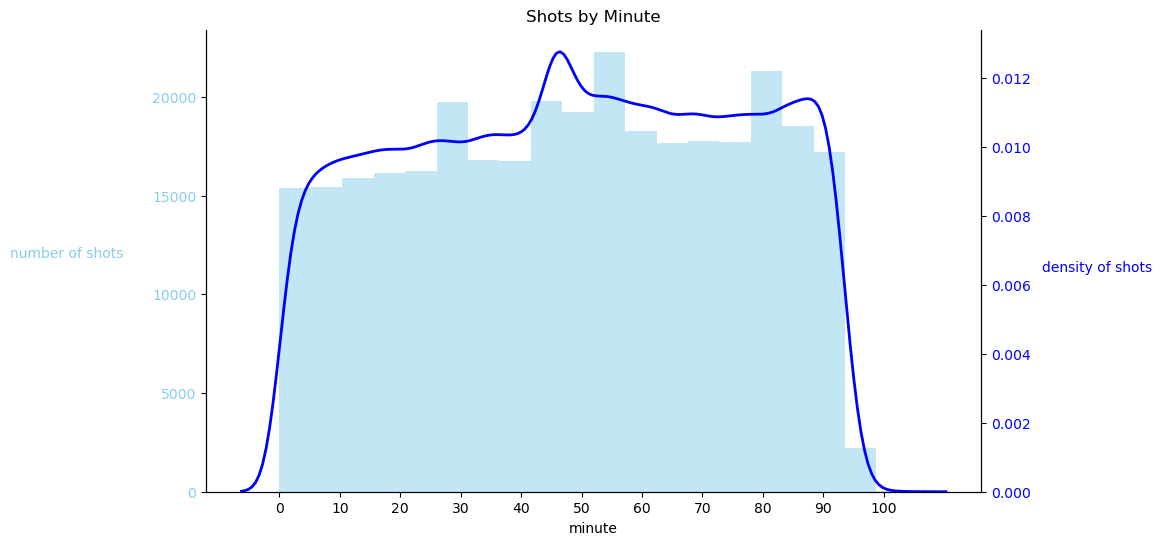

In [5]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.hist(data.minute, bins=20, color='skyblue', alpha=0.5, label='Histogram')
ax1.set_ylabel('number of shots', color='skyblue', rotation=0)
ax1.yaxis.set_label_coords(-0.18, 0.5)
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.spines['top'].set_visible(False)

ax2 = ax1.twinx()

sns.kdeplot(data.minute, ax=ax2, color='blue', linewidth=2, label='Empirical Density')
ax2.set_ylabel('density of shots', color='blue', rotation=0)
ax2.yaxis.set_label_coords(1.15, 0.5)
ax2.tick_params(axis='y', labelcolor='blue')
ax2.spines['top'].set_visible(False)

ax1.set_xlabel('minute')
ax1.set_xticks(np.arange(0, 101, 10))
plt.title('Shots by Minute')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


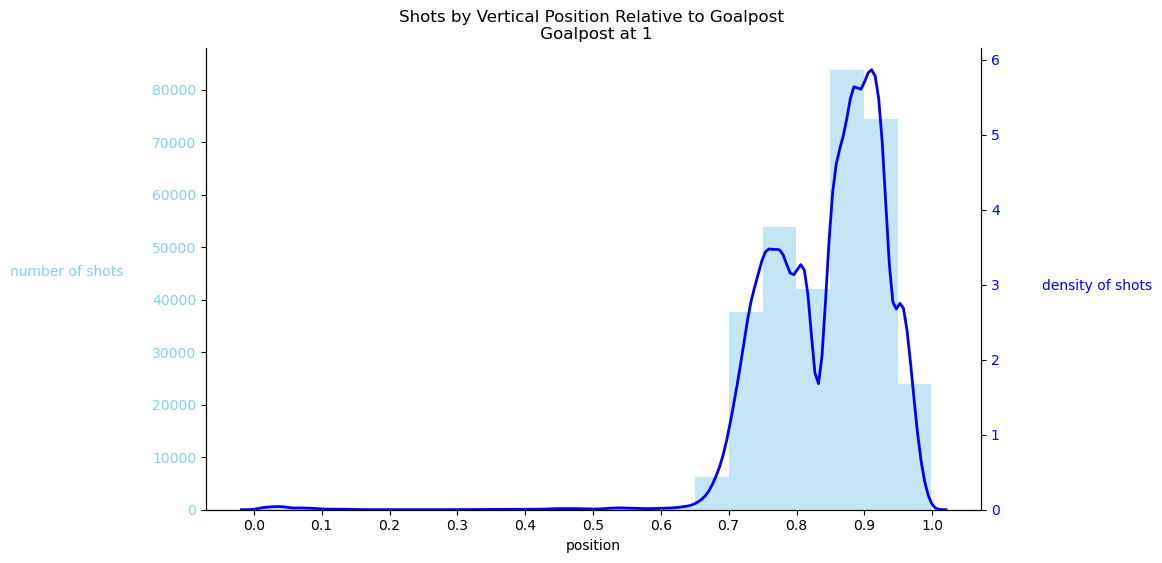

In [6]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.hist(data.positionX, bins=20, color='skyblue', alpha=0.5, label='Histogram')
ax1.set_ylabel('number of shots', color='skyblue', rotation=0)
ax1.yaxis.set_label_coords(-0.18, 0.5)
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.spines['top'].set_visible(False)

ax2 = ax1.twinx()

sns.kdeplot(data.positionX, ax=ax2, color='blue', linewidth=2, label='Empirical Density')
ax2.set_ylabel('density of shots', color='blue', rotation=0)
ax2.yaxis.set_label_coords(1.15, 0.5)
ax2.tick_params(axis='y', labelcolor='blue')
ax2.spines['top'].set_visible(False)

ax1.set_xlabel('position')
ax1.set_xticks(np.arange(0, 1.01, 0.1))
plt.title('Shots by Vertical Position Relative to Goalpost \n Goalpost at 1')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


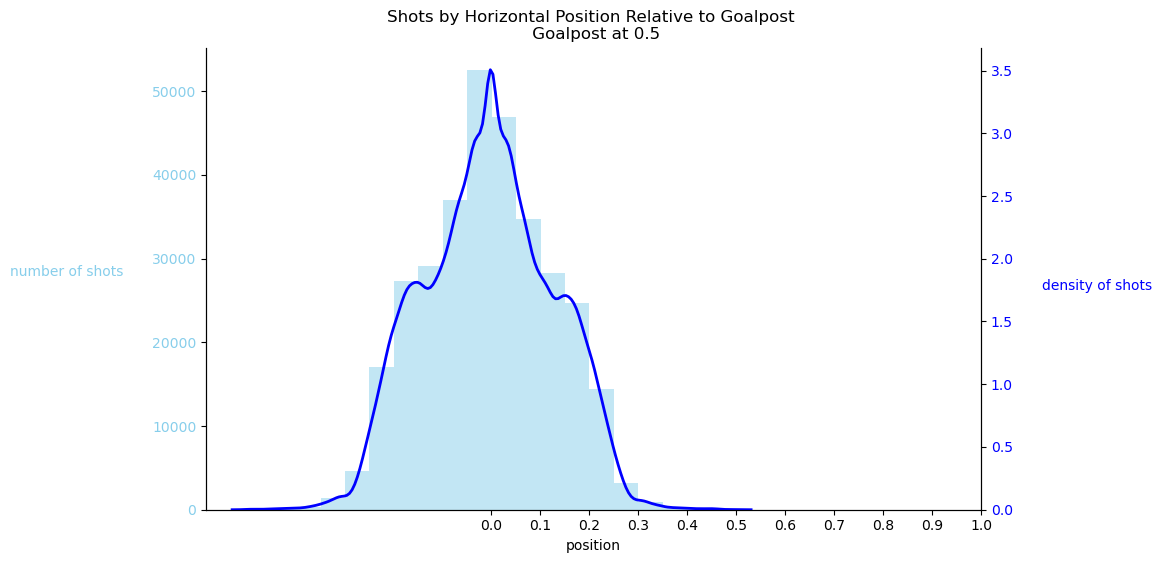

In [58]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.hist(data.positionY, bins=20, color='skyblue', alpha=0.5, label='Histogram')
ax1.set_ylabel('number of shots', color='skyblue', rotation=0)
ax1.yaxis.set_label_coords(-0.18, 0.5)
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.spines['top'].set_visible(False)

ax2 = ax1.twinx()

sns.kdeplot(data.positionY, ax=ax2, color='blue', linewidth=2, label='Empirical Density')
ax2.set_ylabel('density of shots', color='blue', rotation=0)
ax2.yaxis.set_label_coords(1.15, 0.5)
ax2.tick_params(axis='y', labelcolor='blue')
ax2.spines['top'].set_visible(False)

ax1.set_xlabel('position')
ax1.set_xticks(np.arange(0, 1.01, 0.1))
plt.title('Shots by Horizontal Position Relative to Goalpost \n Goalpost at 0.5')
plt.show()

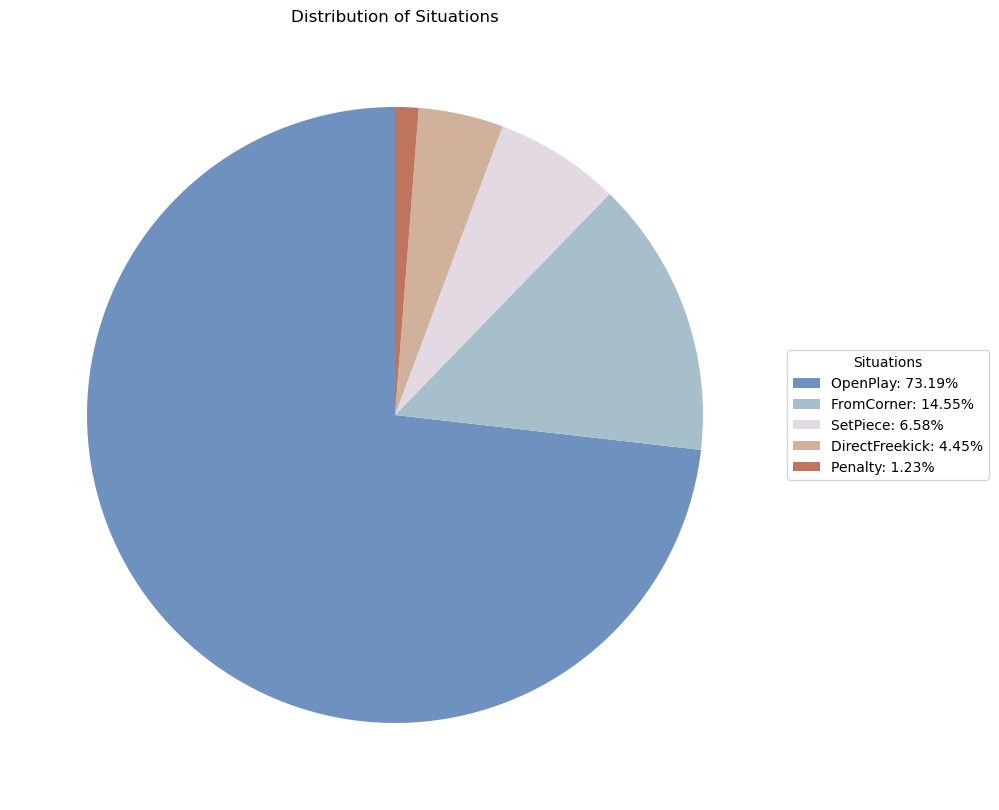

In [8]:
category_counts = data['situation'].value_counts()

plt.figure(figsize=(10, 10))

cmap = plt.get_cmap('twilight_shifted')
colors = [cmap(i) for i in np.linspace(0.3, 0.7, len(category_counts))]

percentages = 100 * category_counts / category_counts.sum()

wedges, texts = plt.pie(
    category_counts,
    startangle=90,
    colors=colors
)

labels_with_percentages = [f"{label}: {percentage:.2f}%" for label, percentage in zip(category_counts.index, percentages)]
plt.legend(
    wedges,
    labels_with_percentages,
    title="Situations",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=10  
)

plt.title('Distribution of Situations')

plt.show()

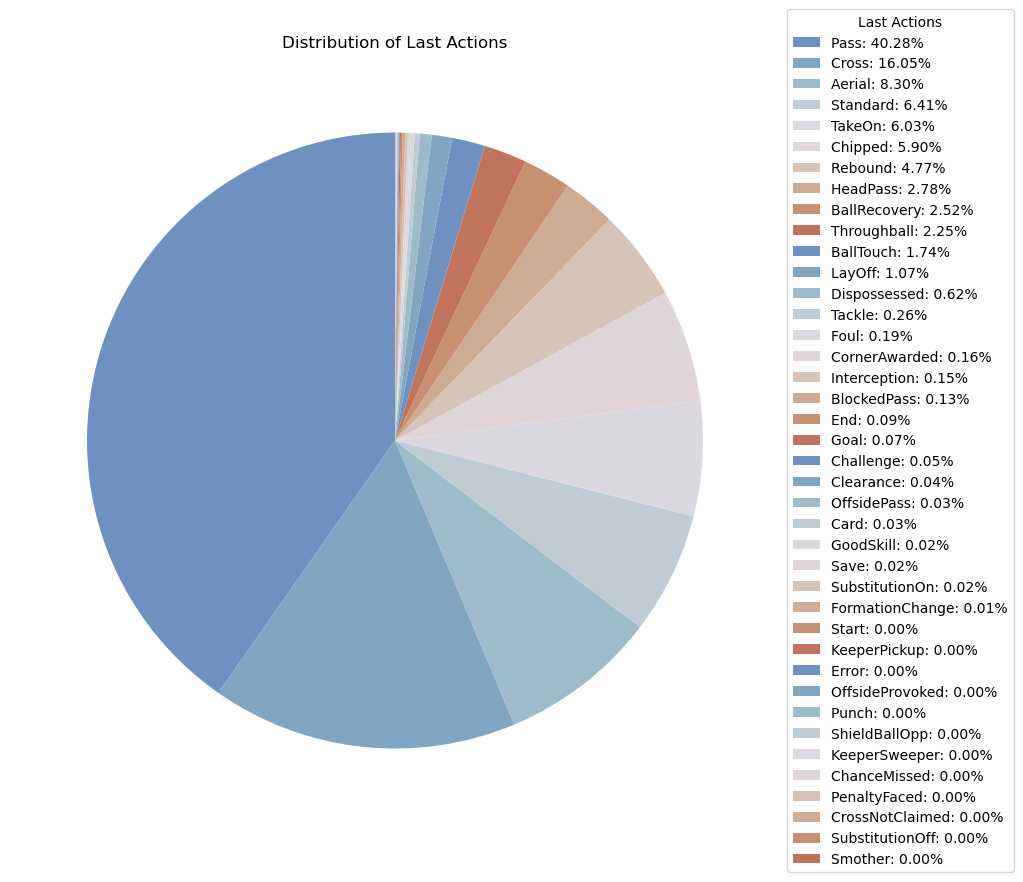

In [9]:
category_counts = data['lastAction'].value_counts()


plt.figure(figsize=(10, 10))

cmap = plt.get_cmap('twilight_shifted')
colors = [cmap(i) for i in np.linspace(0.3, 0.7, 10)]*5


percentages = 100 * category_counts / category_counts.sum()

wedges, texts = plt.pie(
    category_counts,
    startangle=90,
    colors=colors
)

labels_with_percentages = [f"{label}: {percentage:.2f}%" for label, percentage in zip(category_counts.index, percentages)]
plt.legend(
    wedges,
    labels_with_percentages,
    title="Last Actions",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=10
)

plt.title('Distribution of Last Actions')

plt.show()

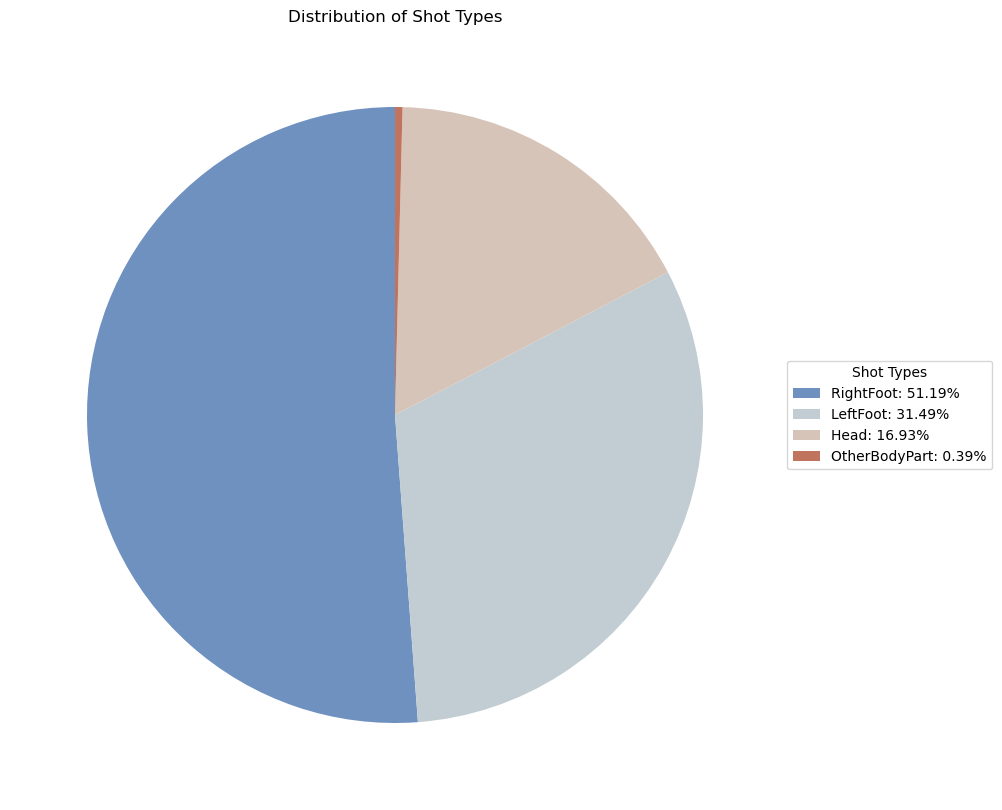

In [10]:
category_counts = data['shotType'].value_counts()


plt.figure(figsize=(10, 10))

cmap = plt.get_cmap('twilight_shifted')
colors = [cmap(i) for i in np.linspace(0.3, 0.7, len(category_counts))]

percentages = 100 * category_counts / category_counts.sum()

wedges, texts = plt.pie(
    category_counts,
    startangle=90,
    colors=colors
)

labels_with_percentages = [f"{label}: {percentage:.2f}%" for label, percentage in zip(category_counts.index, percentages)]
plt.legend(
    wedges,
    labels_with_percentages,
    title="Shot Types",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=10  
)

plt.title('Distribution of Shot Types')

plt.show()

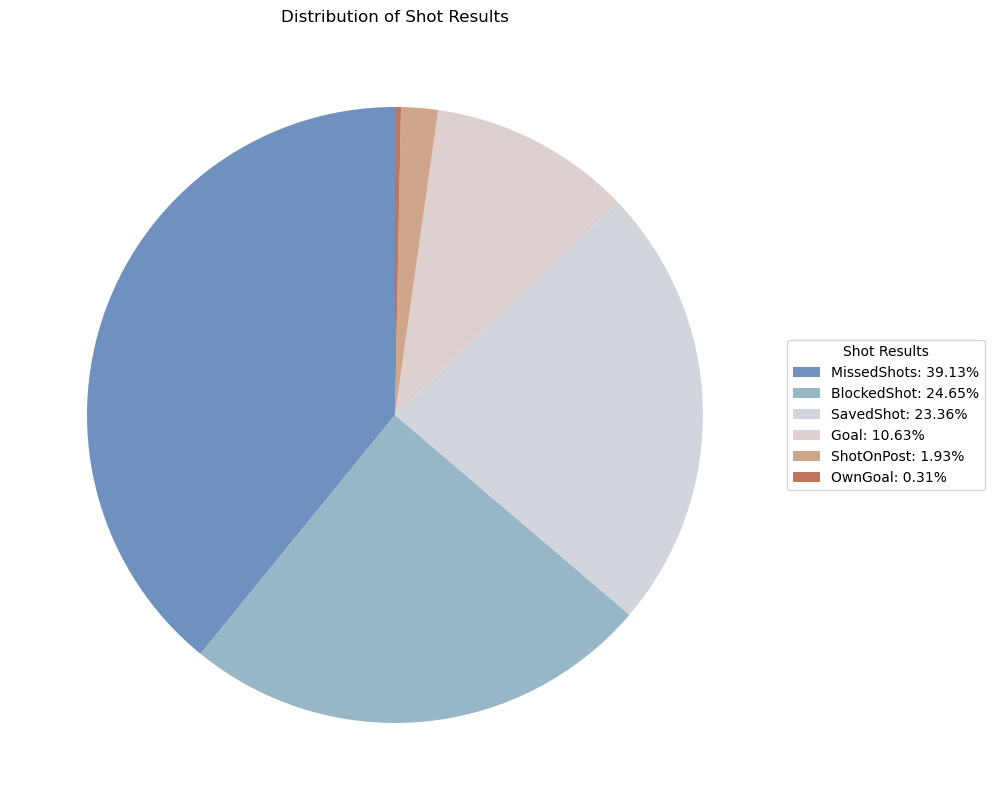

In [189]:
category_counts = data['shotResult'].value_counts()


plt.figure(figsize=(10, 10))

cmap = plt.get_cmap('twilight_shifted')
colors = [cmap(i) for i in np.linspace(0.3, 0.7, len(category_counts))]

percentages = 100 * category_counts / category_counts.sum()

wedges, texts = plt.pie(
    category_counts,
    startangle=90,
    colors=colors
)

labels_with_percentages = [f"{label}: {percentage:.2f}%" for label, percentage in zip(category_counts.index, percentages)]
plt.legend(
    wedges,
    labels_with_percentages,
    title="Shot Results",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=10  
)

plt.title('Distribution of Shot Results')

plt.show()

## Data preprocessing

In [75]:
# data = data[data['lastAction'].isna()==False]
data = data[data['shotType']!='OtherBodyPart']
data['horizontal_dist'] = abs(0.5-data['positionY'])
data['vertical_dist'] = 1-data['positionX']

In [76]:
def has_assister(x):
    if pd.isna(x):
        return False
    else:
        return True
data['has_assister'] = data['assisterID'].apply(has_assister)

In [77]:
def was_passed(x):
    if pd.isna(x):
        return x
    elif x=='Pass':
        return True
    else:
        return False
data['was_passed'] = data['lastAction'].apply(was_passed)

In [78]:
results = data['shotResult'].unique()
d = {}
for r in results:
    if 'Goal' in r:
        d[r] = 1
    else:
        d[r] = 0
data['is_goal'] = data['shotResult'].map(d)

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 323276 entries, 0 to 324542
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gameID                323276 non-null  int64  
 1   shooterID             323276 non-null  int64  
 2   assisterID            239219 non-null  float64
 3   minute                323276 non-null  int64  
 4   situation             323276 non-null  object 
 5   lastAction            286499 non-null  object 
 6   shotType              323276 non-null  object 
 7   shotResult            323276 non-null  object 
 8   xGoal                 323276 non-null  float64
 9   positionX             323276 non-null  float64
 10  positionY             323276 non-null  float64
 11  horizontal_dist       323276 non-null  float64
 12  vertical_dist         323276 non-null  float64
 13  has_assister          323276 non-null  bool   
 14  was_passed            286499 non-null  object 
 15  is_go

In [80]:
data.head(20)

,gameID,shooterID,assisterID,minute,situation,lastAction,shotType,shotResult,xGoal,positionX,positionY,horizontal_dist,vertical_dist,has_assister,was_passed,is_goal,3cat,dummy_assister,dummy_pass,dummy_FromCorner,dummy_SetPiece,dummy_DirectFreekick,dummy_Penalty,dummy_LeftFoot,dummy_Head
0,239,641,NaN,43,OpenPlay,Rebound,LeftFoot,MissedShots,0.289045,0.923,0.682,0.182,0.077,False,False,0,1,0,0,0,0,0,0,1,0
1,7166,652,NaN,90,FromCorner,NaN,RightFoot,MissedShots,0.016110,0.755,0.614,0.114,0.245,False,NaN,0,1,0,0,1,0,0,0,0,0
2,15149,5074,2586.0,29,OpenPlay,Pass,RightFoot,SavedShot,0.032673,0.884,0.304,0.196,0.116,True,True,0,0,1,1,0,0,0,0,0,0
3,349,671,668.0,85,OpenPlay,Pass,RightFoot,BlockedShot,0.040605,0.856,0.294,0.206,0.144,True,True,0,0,1,1,0,0,0,0,0,0
4,4273,5687,NaN,79,OpenPlay,BallRecovery,RightFoot,Goal,0.324743,0.932,0.651,0.151,0.068,False,False,1,2,0,0,0,0,0,0,0,0
5,10003,2547,2242.0,3,FromCorner,Pass,LeftFoot,MissedShots,0.023090,0.755,0.699,0.199,0.245,True,True,0,1,1,1,1,0,0,0,1,0
6,10790,5608,NaN,7,DirectFreekick,Standard,RightFoot,SavedShot,0.056479,0.782,0.714,0.214,0.218,False,False,0,0,0,0,0,0,1,0,0,0
7,16074,6884,6762.0,43,OpenPlay,Pass,LeftFoot,SavedShot,0.035887,0.915,0.724,0.224,0.085,True,True,0,0,1,1,0,0,0,0,1,0
8,3314,2323,5093.0,22,FromCorner,Cross,Head,Goal,0.106911,0.917,0.511,0.011,0.083,True,False,1,2,1,0,1,0,0,0,0,1
9,2198,3252,967.0,17,OpenPlay,Pass,RightFoot,MissedShots,0.079919,0.964,0.343,0.157,0.036,True,True,0,1,1,1,0,0,0,0,0,0


In [65]:
data.describe()

,gameID,shooterID,assisterID,minute,xGoal,positionX,positionY,horizontal_dist,vertical_dist,is_goal,3cat,dummy_assister,dummy_pass,dummy_FromCorner,dummy_SetPiece,dummy_DirectFreekick,dummy_Penalty,dummy_LeftFoot,dummy_Head
count,323276.000000,323276.000000,239219.000000,323276.000000,323276.000000,323276.000000,323276.000000,323276.000000,323276.000000,323276.000000,323276.000000,323276.000000,323276.000000,323276.000000,323276.000000,323276.000000,323276.000000,323276.000000,323276.000000
mean,7829.576458,2690.201546,2685.418157,48.567048,0.108475,0.844147,0.504632,-0.004632,0.155853,0.108712,0.627690,0.739984,0.358316,0.144607,0.065306,0.044696,0.012333,0.316123,0.170010
std,4729.850509,2272.347559,2285.713903,26.579177,0.160456,0.088015,0.129573,0.129573,0.088015,0.311278,0.671655,0.438644,0.479506,0.351705,0.247066,0.206635,0.110368,0.464962,0.375642
min,81.000000,2.000000,1.000000,0.000000,0.000000,0.003000,0.000000,-0.497000,0.001000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3806.000000,845.000000,835.000000,26.000000,0.024035,0.781000,0.413000,-0.097000,0.092000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7962.000000,2080.000000,2094.000000,49.000000,0.049924,0.862000,0.501000,-0.001000,0.138000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,11951.000000,3781.000000,3743.000000,71.000000,0.094284,0.908000,0.597000,0.087000,0.219000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,16135.000000,9567.000000,9567.000000,103.000000,0.979887,0.999000,0.997000,0.500000,0.997000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [81]:
data['has_assister'].mean()

0.7399837909402492

In [82]:
data.groupby('is_goal')['has_assister'].mean()

is_goal
0    0.746231
1    0.688766
Name: has_assister, dtype: float64

In [83]:
data['was_passed'].mean()

0.40431205693562633

In [84]:
data.groupby('is_goal')['was_passed'].mean()

is_goal
0    0.416776
1    0.305202
Name: was_passed, dtype: object

## Model Selection

In [85]:
s_full = 'is_goal ~ minute + vertical_dist + horizontal_dist + C(has_assister) + C(was_passed) + C(situation, Treatment(reference="OpenPlay")) + C(shotType, Treatment(reference="RightFoot"))'

In [86]:
xvars = [x.strip() for x  in s_full.split('~')[1].split('+')]
print(xvars)

['minute', 'vertical_dist', 'horizontal_dist', 'C(has_assister)', 'C(was_passed)', 'C(situation, Treatment(reference="OpenPlay"))', 'C(shotType, Treatment(reference="RightFoot"))']


In [87]:
specifications = []
for r in range(1, len(xvars) + 1):
    combinations = itertools.combinations(xvars, r)
    for combo in combinations:
        specifications.append(combo)

In [88]:
def get_criteria(specification,data):
    model = smf.ols(formula=specification, data=data).fit()
    adjusted_r2 = model.rsquared_adj
    ols_aic = model.aic
    ols_bic = model.bic
    model = smf.logit(formula=specification, data=data).fit()
    logit_aic = model.aic
    logit_bic = model.bic
    pseudo_r2 = 1 - (model.llf / model.llnull)
    return np.round([adjusted_r2, ols_aic, ols_bic, pseudo_r2, logit_aic, logit_bic],3)

In [89]:
ols_r2 = {}
ols_aic = {}
ols_bic = {}
logit_r2 = {}
logit_aic = {}
logit_bic = {}
for i,s in enumerate(specifications):
    specification = 'is_goal ~ ' + ' + '.join(s)
    d = get_criteria(specification,data)
    ols_r2[s] = d[0]
    ols_aic[s] = d[1]
    ols_bic[s] = d[2]
    logit_r2[s] = d[3]
    logit_aic[s] = d[4]
    logit_bic[s] = d[5]
    print('')
    print(f'Specification {i+1} done')
    print('')

Optimization terminated successfully.
         Current function value: 0.343702
         Iterations 6

Specification 1 done

Optimization terminated successfully.
         Current function value: 0.334050
         Iterations 7

Specification 2 done

Optimization terminated successfully.
         Current function value: 0.324480
         Iterations 7

Specification 3 done

Optimization terminated successfully.
         Current function value: 0.343010
         Iterations 6

Specification 4 done

Optimization terminated successfully.
         Current function value: 0.347434
         Iterations 6

Specification 5 done

Optimization terminated successfully.
         Current function value: 0.327936
         Iterations 7

Specification 6 done

Optimization terminated successfully.
         Current function value: 0.343734
         Iterations 6

Specification 7 done

Optimization terminated successfully.
         Current function value: 0.333968
         Iterations 7

Specification 8 done



In [90]:
def get_best(d,high_is_good):
    if high_is_good==True:
        d = sorted(d.items(),key = lambda x: -x[1])
    else:
        d = sorted(d.items(),key = lambda x: x[1])
    return d[0][0]

In [91]:
print(get_best(ols_r2,True))
print(get_best(ols_aic,False))
print(get_best(ols_bic,False))
print(get_best(logit_r2,True))
print(get_best(logit_aic,False))
print(get_best(logit_bic,False))

('vertical_dist', 'horizontal_dist', 'C(has_assister)', 'C(was_passed)', 'C(situation, Treatment(reference="OpenPlay"))', 'C(shotType, Treatment(reference="RightFoot"))')
('minute', 'vertical_dist', 'horizontal_dist', 'C(has_assister)', 'C(was_passed)', 'C(situation, Treatment(reference="OpenPlay"))', 'C(shotType, Treatment(reference="RightFoot"))')
('vertical_dist', 'horizontal_dist', 'C(has_assister)', 'C(was_passed)', 'C(situation, Treatment(reference="OpenPlay"))', 'C(shotType, Treatment(reference="RightFoot"))')
('vertical_dist', 'horizontal_dist', 'C(has_assister)', 'C(was_passed)', 'C(situation, Treatment(reference="OpenPlay"))', 'C(shotType, Treatment(reference="RightFoot"))')
('minute', 'vertical_dist', 'horizontal_dist', 'C(has_assister)', 'C(was_passed)', 'C(situation, Treatment(reference="OpenPlay"))', 'C(shotType, Treatment(reference="RightFoot"))')
('vertical_dist', 'horizontal_dist', 'C(has_assister)', 'C(was_passed)', 'C(situation, Treatment(reference="OpenPlay"))', 'C(

## OLS & Logistic Regressions

In [92]:
s_full = 'is_goal ~ minute + vertical_dist + horizontal_dist + C(has_assister) + C(was_passed) + C(situation, Treatment(reference="OpenPlay")) + C(shotType, Treatment(reference="RightFoot"))'
s_n_full = 'is_goal ~ minute + vertical_dist + horizontal_dist + C(has_assister) + C(situation, Treatment(reference="OpenPlay")) + C(shotType, Treatment(reference="RightFoot"))'

In [93]:
ols_model  = smf.ols(s_full,data=data).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                is_goal   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     3183.
Date:                Sun, 06 Oct 2024   Prob (F-statistic):               0.00
Time:                        18:18:37   Log-Likelihood:                -59060.
No. Observations:              286499   AIC:                         1.181e+05
Df Residuals:                  286487   BIC:                         1.183e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [94]:
logit_f_model  = smf.logit(s_full,data=data).fit()
print(logit_f_model.summary())

Optimization terminated successfully.
         Current function value: 0.303761
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                is_goal   No. Observations:               286499
Model:                          Logit   Df Residuals:                   286487
Method:                           MLE   Df Model:                           11
Date:                Sun, 06 Oct 2024   Pseudo R-squ.:                  0.1323
Time:                        18:18:42   Log-Likelihood:                -87027.
converged:                       True   LL-Null:                   -1.0030e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
In

In [95]:
logit_model  = smf.logit(s_n_full,data=data).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.303854
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                is_goal   No. Observations:               323276
Model:                          Logit   Df Residuals:                   323265
Method:                           MLE   Df Model:                           10
Date:                Sun, 06 Oct 2024   Pseudo R-squ.:                  0.1162
Time:                        18:18:44   Log-Likelihood:                -98229.
converged:                       True   LL-Null:                   -1.1115e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
In

## QQ Plots

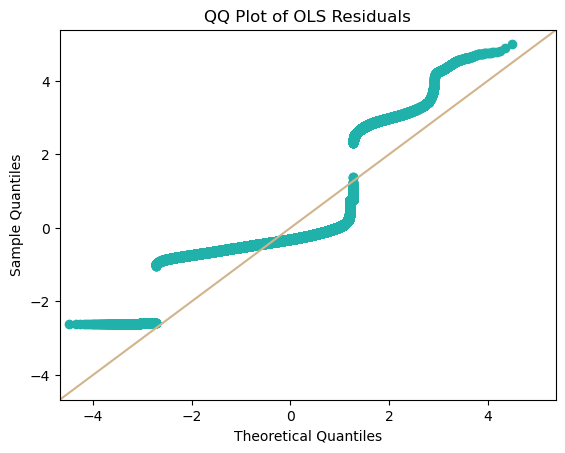

In [96]:
residuals = ols_model.resid

standardized_residuals = (residuals-np.mean(residuals))/np.std(residuals)

qq_plot=sm.qqplot(standardized_residuals, markerfacecolor='lightseagreen', markeredgecolor='lightseagreen', line='45')
plt.gca().get_lines()[1].set_color('tan')
plt.title('QQ Plot of OLS Residuals')
plt.show()

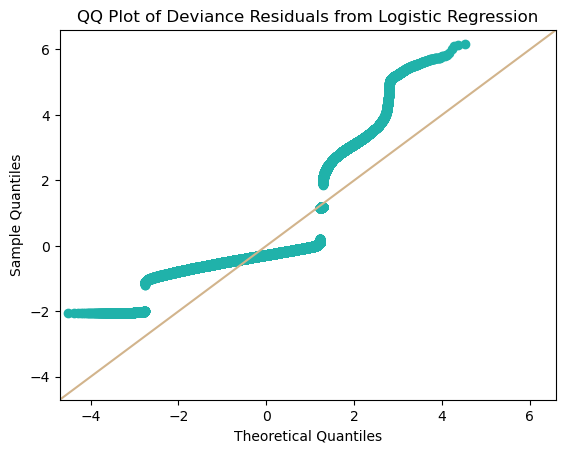

In [97]:
pred_probs = logit_model.predict(data)

observed = data['is_goal']

deviance_residuals = np.sign(observed - pred_probs) * np.sqrt(
    -2 * (observed * np.log(pred_probs) + (1 - observed) * np.log(1 - pred_probs))
)

standardized_residuals = (deviance_residuals-np.mean(deviance_residuals))/np.std(deviance_residuals)

qq_plot=sm.qqplot(standardized_residuals, markerfacecolor='lightseagreen', markeredgecolor='lightseagreen', line='45')
plt.gca().get_lines()[1].set_color('tan')
plt.title('QQ Plot of Deviance Residuals from Logistic Regression')
plt.show()

## Correlation and VIF

In [98]:
data[['vertical_dist','horizontal_dist','minute']].corr()

,vertical_dist,horizontal_dist,minute
vertical_dist,1.000000,0.105854,-0.016281
horizontal_dist,0.105854,1.000000,-0.023300
minute,-0.016281,-0.023300,1.000000


In [99]:
X = data[['vertical_dist','horizontal_dist','minute']]

X = sm.add_constant(X)

vif = pd.DataFrame()
vif['features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif.head()

,features,VIF
0,const,9.117304
1,vertical_dist,1.011527
2,horizontal_dist,1.011809
3,minute,1.000736


Checking for categorical variables

In [101]:
print(cramers_v(data['has_assister'],data['shotType']))
print(chi_square_test(data['has_assister'],data['shotType']))
print(cramers_v(data['has_assister'],data['situation']))
print(chi_square_test(data['has_assister'],data['situation']))
print(cramers_v(data['shotType'],data['situation']))
print(chi_square_test(data['shotType'],data['situation']))

0.2184022863706111
(15420.122535686032, 0.0)
0.4232820428278173
(57920.61343492573, 0.0)
0.2941817358500823
(55954.481012544544, 0.0)


Cramér's V gives a value between 0 and 1, where:

0: No association between the variables.
1: Perfect association between the variables.

For each pair of variables:

Cramér's V for has_assister and shotType: 0.218
This suggests a weak to moderate association between these two variables. While they are not completely independent, the relationship isn't very strong.

Cramér's V for has_assister and situation: 0.423
This indicates a moderate association. There is a stronger relationship here, which could be important for our model.

Cramér's V for shotType and situation: 0.294
This also suggests a moderate association, although not as strong as has_assister and situation.

## Influential Points

In [35]:
influence = ols_model.get_influence()
# highest Cook's distance
cooks_d = influence.cooks_distance[0]
print('Top 20 values in terms of Cook\'s distance for OLS regression:')
print(np.sort(cooks_d)[::-1][:20])

Top 20 values in terms of Cook's distance for OLS regression:
[0.00106874 0.00106436 0.00104911 0.00104707 0.00104454 0.00103741
 0.00103595 0.00102523 0.00102379 0.00101797 0.00101359 0.00101147
 0.00101117 0.00101116 0.00100594 0.00100512 0.0010003  0.00099993
 0.00099697 0.00099134]


In [36]:
influence = logit_model.get_influence()
# highest Cook's distance
cooks_d = influence.cooks_distance[0]
print('Top 20 values in terms of Cook\'s distance for logistic regression:')
print(np.sort(cooks_d)[::-1][:20])

Top 20 values in terms of Cook's distance for logistic regression:
[0.0007394  0.00072811 0.00072709 0.0007234  0.00072284 0.00072165
 0.00071729 0.00071264 0.00071111 0.00070961 0.00070917 0.00070735
 0.0007072  0.00070592 0.00070466 0.00070402 0.00070378 0.0007022
 0.00069929 0.00069875]


## Filtering For Attackers

In [37]:
shots_per_player = data['shooterID'].value_counts()

players_with_more_than_n_shots = shots_per_player[shots_per_player >= 210].index

filtered_df = data[data['shooterID'].isin(players_with_more_than_n_shots)]

filtered_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 122019 entries, 2 to 324541
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   gameID           122019 non-null  int64  
 1   shooterID        122019 non-null  int64  
 2   assisterID       93291 non-null   float64
 3   minute           122019 non-null  int64  
 4   situation        122019 non-null  object 
 5   lastAction       111453 non-null  object 
 6   shotType         122019 non-null  object 
 7   shotResult       122019 non-null  object 
 8   xGoal            122019 non-null  float64
 9   positionX        122019 non-null  float64
 10  positionY        122019 non-null  float64
 11  horizontal_dist  122019 non-null  float64
 12  vertical_dist    122019 non-null  float64
 13  has_assister     122019 non-null  bool   
 14  was_passed       111453 non-null  object 
 15  is_goal          122019 non-null  int64  
dtypes: bool(1), float64(6), int64(4), object(5)

In [38]:
ols_model  = smf.ols(s_full,data=filtered_df).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                is_goal   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     1711.
Date:                Sun, 06 Oct 2024   Prob (F-statistic):               0.00
Time:                        17:24:03   Log-Likelihood:                -30098.
No. Observations:              111453   AIC:                         6.022e+04
Df Residuals:                  111441   BIC:                         6.033e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [39]:
logit_model  = smf.logit(s_full,data=filtered_df).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.330275
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                is_goal   No. Observations:               111453
Model:                          Logit   Df Residuals:                   111441
Method:                           MLE   Df Model:                           11
Date:                Sun, 06 Oct 2024   Pseudo R-squ.:                  0.1691
Time:                        17:24:04   Log-Likelihood:                -36810.
converged:                       True   LL-Null:                       -44302.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
In

## Multinomial Logistic (Softmax) Regression

In [40]:
data['shotResult'].unique()

array(['MissedShots', 'SavedShot', 'BlockedShot', 'Goal', 'ShotOnPost',
       'OwnGoal'], dtype=object)

In [41]:
cat_mapping = {}
cat_mapping[0] = 'off_target'
cat_mapping[1] = 'on_target' #but not goal
cat_mapping[2] = 'goal'

In [42]:
shot_mapping = {}
shot_mapping['MissedShots'] = 0
shot_mapping['ShotOnPost'] = 0
shot_mapping['SavedShot'] = 1
shot_mapping['BlockedShot'] = 1
shot_mapping['Goal'] = 2
shot_mapping['OwnGoal'] = 2
data['3cat'] = data['shotResult'].map(shot_mapping)
data.head(20)

,gameID,shooterID,assisterID,minute,situation,lastAction,shotType,shotResult,xGoal,positionX,positionY,horizontal_dist,vertical_dist,has_assister,was_passed,is_goal,3cat
0,239,641,NaN,43,OpenPlay,Rebound,LeftFoot,MissedShots,0.289045,0.923,0.682,0.182,0.077,False,False,0,0
1,7166,652,NaN,90,FromCorner,NaN,RightFoot,MissedShots,0.016110,0.755,0.614,0.114,0.245,False,NaN,0,0
2,15149,5074,2586.0,29,OpenPlay,Pass,RightFoot,SavedShot,0.032673,0.884,0.304,0.196,0.116,True,True,0,1
3,349,671,668.0,85,OpenPlay,Pass,RightFoot,BlockedShot,0.040605,0.856,0.294,0.206,0.144,True,True,0,1
4,4273,5687,NaN,79,OpenPlay,BallRecovery,RightFoot,Goal,0.324743,0.932,0.651,0.151,0.068,False,False,1,2
5,10003,2547,2242.0,3,FromCorner,Pass,LeftFoot,MissedShots,0.023090,0.755,0.699,0.199,0.245,True,True,0,0
6,10790,5608,NaN,7,DirectFreekick,Standard,RightFoot,SavedShot,0.056479,0.782,0.714,0.214,0.218,False,False,0,1
7,16074,6884,6762.0,43,OpenPlay,Pass,LeftFoot,SavedShot,0.035887,0.915,0.724,0.224,0.085,True,True,0,1
8,3314,2323,5093.0,22,FromCorner,Cross,Head,Goal,0.106911,0.917,0.511,0.011,0.083,True,False,1,2
9,2198,3252,967.0,17,OpenPlay,Pass,RightFoot,MissedShots,0.079919,0.964,0.343,0.157,0.036,True,True,0,0


In [43]:
data['3cat'].value_counts(normalize=True)

3cat
1    0.481022
0    0.410266
2    0.108712
Name: proportion, dtype: float64

In [44]:
data['dummy_assister'] = (data['has_assister']==True).astype(int)

data['dummy_pass'] = (data['was_passed']==True).astype(int)

data['dummy_FromCorner'] = (data['situation']=='FromCorner').astype(int)
data['dummy_SetPiece'] = (data['situation']=='SetPiece').astype(int)
data['dummy_DirectFreekick'] = (data['situation']=='DirectFreekick').astype(int)
data['dummy_Penalty'] = (data['situation']=='Penalty').astype(int)

data['dummy_LeftFoot'] = (data['shotType']=='LeftFoot').astype(int)
data['dummy_Head'] = (data['shotType']=='Head').astype(int)

In [45]:
data.head()

,gameID,shooterID,assisterID,minute,situation,lastAction,shotType,shotResult,xGoal,positionX,positionY,horizontal_dist,vertical_dist,has_assister,was_passed,is_goal,3cat,dummy_assister,dummy_pass,dummy_FromCorner,dummy_SetPiece,dummy_DirectFreekick,dummy_Penalty,dummy_LeftFoot,dummy_Head
0,239,641,NaN,43,OpenPlay,Rebound,LeftFoot,MissedShots,0.289045,0.923,0.682,0.182,0.077,False,False,0,0,0,0,0,0,0,0,1,0
1,7166,652,NaN,90,FromCorner,NaN,RightFoot,MissedShots,0.016110,0.755,0.614,0.114,0.245,False,NaN,0,0,0,0,1,0,0,0,0,0
2,15149,5074,2586.0,29,OpenPlay,Pass,RightFoot,SavedShot,0.032673,0.884,0.304,0.196,0.116,True,True,0,1,1,1,0,0,0,0,0,0
3,349,671,668.0,85,OpenPlay,Pass,RightFoot,BlockedShot,0.040605,0.856,0.294,0.206,0.144,True,True,0,1,1,1,0,0,0,0,0,0
4,4273,5687,NaN,79,OpenPlay,BallRecovery,RightFoot,Goal,0.324743,0.932,0.651,0.151,0.068,False,False,1,2,0,0,0,0,0,0,0,0


In [46]:
data.columns

Index(['gameID', 'shooterID', 'assisterID', 'minute', 'situation',
       'lastAction', 'shotType', 'shotResult', 'xGoal', 'positionX',
       'positionY', 'horizontal_dist', 'vertical_dist', 'has_assister',
       'was_passed', 'is_goal', '3cat', 'dummy_assister', 'dummy_pass',
       'dummy_FromCorner', 'dummy_SetPiece', 'dummy_DirectFreekick',
       'dummy_Penalty', 'dummy_LeftFoot', 'dummy_Head'],
      dtype='object')

In [47]:
# s_full
X = data[['minute','horizontal_dist','vertical_dist', 'dummy_assister', 'dummy_pass', 'dummy_FromCorner', 'dummy_SetPiece',
       'dummy_DirectFreekick','dummy_Penalty', 'dummy_LeftFoot', 'dummy_Head']]
y = data[['3cat']]
X = sm.add_constant(X)

In [48]:
mnl_model  = sm.MNLogit(y,X).fit()
print(mnl_model.summary())

Optimization terminated successfully.
         Current function value: 0.902679
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                   3cat   No. Observations:               323276
Model:                        MNLogit   Df Residuals:                   323252
Method:                           MLE   Df Model:                           22
Date:                Sun, 06 Oct 2024   Pseudo R-squ.:                 0.05853
Time:                        17:24:16   Log-Likelihood:            -2.9181e+05
converged:                       True   LL-Null:                   -3.0996e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
              3cat=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5857      0.016     35.521      0.000       0.553       0.618

In [49]:
shot_mapping = {}
shot_mapping['MissedShots'] = 1 #off_target
shot_mapping['ShotOnPost'] = 1
shot_mapping['SavedShot'] = 0 #on_target but not goal
shot_mapping['BlockedShot'] = 0
shot_mapping['Goal'] = 2 #goal
shot_mapping['OwnGoal'] = 2
data['3cat'] = data['shotResult'].map(shot_mapping)
y = data[['3cat']]
mnl_model  = sm.MNLogit(y,X).fit()
print(mnl_model.summary())

Optimization terminated successfully.
         Current function value: 0.902679
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                   3cat   No. Observations:               323276
Model:                        MNLogit   Df Residuals:                   323252
Method:                           MLE   Df Model:                           22
Date:                Sun, 06 Oct 2024   Pseudo R-squ.:                 0.05853
Time:                        17:24:22   Log-Likelihood:            -2.9181e+05
converged:                       True   LL-Null:                   -3.0996e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
              3cat=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.5857      0.016    -35.521      0.000      -0.618      -0.553

## Interaction between shotType and positionY

In [111]:
def dist_group(value, threshold=0.2):
    if value < (threshold*(-1)):
        return 'negative'
    elif value > threshold:
        return 'positive'
    else:
        return 'near_zero'

In [ ]:
thresholds = [0, 0.1, 0.15]

In [ ]:
for t in thresholds:
    data['horizontal_dist_group'] = data['horizontal_dist'].apply(lambda x: dist_group(x,t))
    data['shot_horizontal_interaction'] = data['shotType'] + '_' + data['horizontal_dist_group']
